# Planaria single-cell

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import pyemb as eb

In [2]:
Y = np.array(pd.read_csv('data/planaria_sample_data.csv', index_col=0))
(n,p) = Y.shape
print('Data matrix is', n, 'samples by', p, 'features')

labels = np.genfromtxt('data/sample_annotation_5000.txt', delimiter=',', dtype=str) 
ordered_cats = np.genfromtxt('data/planaria_ordered_cats.csv', delimiter=',', dtype=str)

colors = pd.read_csv('data/colors_dataset.txt', header=None, sep='\t')
colors = {k: c for k, c in colors.values}

Data matrix is 5000 samples by 5821 features


In [3]:
dim = 20
zeta = p**-.5 * eb.embed(Y, d=dim, version='full')

In [4]:
tree = eb.ConstructTree(zeta, epsilon=0.25)
tree.fit()

Performing clustering...
Calculating branch lengths...
Constructing tree...


100%|██████████| 250/250 [00:03<00:00, 79.07it/s]


BarnesHut Approximation  took  1.92  seconds
Repulsion forces  took  1.03  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.09  seconds


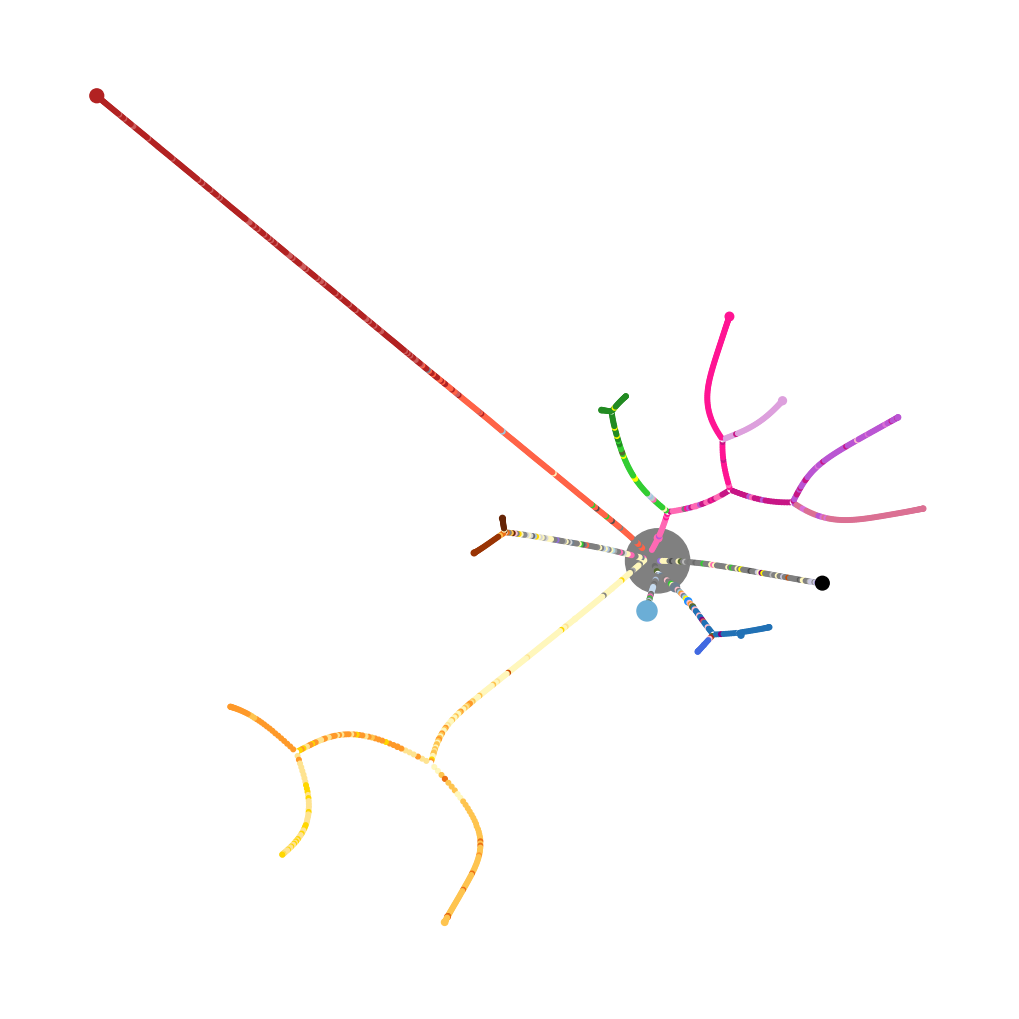

In [5]:
tree.plot(labels,colors, prog = 'twopi')